In [1]:
# %load quick_imports.txt
import random

import numpy as np
import matplotlib.pyplot as plt

# Bokeh imports
from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure, output_file, ColumnDataSource, reset_output
from bokeh.models import HoverTool
output_notebook()

from ipywidgets.widgets import Text

#scipy constants
from scipy.constants import Boltzmann as kB
from scipy.constants import Avogadro as NA
from scipy.constants import Planck as h
from scipy.constants import speed_of_light as c0
from scipy.constants import R

Loading BokehJS ...

In [2]:
L_nm = 300  # length of the nanotube
R_nm = 1  # radius of the exiton
N_DEF = 10  # number of defects per nanotube
T_STEP_ps = 1 # time step
D_exc_nm_per_s = 1.07e15  # Exciton Diffusion Coefficient https://doi.org/10.1021/nn101612b

In [3]:
def photons_fate(n_photons, func, func_kwargs={}):
    """Simulate the fate of numerous photons.
    For a key to the fate look a the respective exciton fate function.

    Parameters
    ----------
    n_photons : int
        Number of photons to be used in the simulation.
    func : callable
        Function to perform MC simulation of a single exciton.
    func_kwargs: dict
        Dictionary containing the arguments and keyword arguments for
        func.

    Returns
    -------
    photons_fate : 1D array
        Binnend fate of the photons in simulation.
    quantum_yield : 1D array
        Quantum yield of the E11 and E11* radiative decay."""
    info = Text()
    display(info)

    # initiate matrix size
    photons_fate = func(**func_kwargs)
    info.value = f"Processing photon (1/ {n_photons})"

    # loop for the desired number of photons
    for p in np.arange(n_photons-1):
        photons_fate += func(**func_kwargs)
        info.value = f"Processing photon ({p+2}/ {n_photons})"

    # calculate the quantum yield
    quantum_yield = photons_fate[:2] / n_photons

    return photons_fate, quantum_yield

In [4]:
def create_defects(length=L_nm, n_def=N_DEF):
    """Creates defects along the CNT at random position.

    Parameters
    ----------
    length : int, optional
        Length of the CNT in nm, global constant as default.
    n_def : int, optional
        Number of defects on the CNT, global constant as default.

    Returns
    -------
    pos_def : 1D array
        Positions in nm of the defects on the CNT stored in
        array size (n_def, 1)
    """
    return np.random.randint(0, length, size=(n_def, 1))

In [5]:
def create_exciton(length=L_nm):
    """Creates exciton on the CNT at random position.

    Parameters
    ----------
    length : int, optional
        Length of the CNT in nm, global constant as default.

    Returns
    -------
    pos_exc : int
        Position of the exciton along the CNT as a random integer."""
    return random.randrange(length)

In [6]:
def exciton_walk(t_step, n_defects=10, length=L_nm):
    """
    
    Parameters
    ----------
    t_step : float
        Timestep in ps.
    n_defects : int, optional
        Number of defects on CNT. Default is 10
    length : int, optional
        Length of the CNT in nm, global constant as default.

    Returns
    -------
    exciton_fate : 1D array
        Array contains the binned fate of the exciton for each MC step:
        fate = 0 : E11* radiative decay
        fate = 1 : E11 radiative decay
        fate = 2 : E11* non-radiative decay
        fate = 3 : E11 non-radiative decay
        fate = 4 : Exciton stays in trap
        fate = 5 : Free diffusion walk
        fate = 6 : Exciton escapes trap
        fate = 7 : Exciton becomes trapped
    """

    kin_const = [k_d_r_per_s, k_r_per_s, k_d_nr_per_s, k_nr_per_s,
                 k_nothing_d(t_step), k_nothing(t_step), k_dt_per_s]

    # inital exciton is free in E11
    fate = 4
    trapped = 0

    # Initiate matrix to store exciton fate
    exciton_fate = np.zeros(len(kin_const)+1)

    # Inital position of the exciton and defects
    pos_exc_0 = create_exciton(length)
    defects = create_defects(length, n_defects)

    while fate > 3:

        # step if exciton is free
        if trapped == 0:
            pos_exc_1 = round(pos_exc_0 + (
                2 * D_exc_nm_per_s * t_step * 1e-12)**0.5)

        # quenching of the exciton at tube end
        if pos_exc_1 >= length:
            fate = 3
            exciton_fate[fate] += 1
            break

        # check if exciton became trapped
        if trapped == 0:
            pathway = np.arange(pos_exc_1-pos_exc_0)
            if np.in1d(pathway, defects).any():
                trapped = 1
                fate = 7
                exciton_fate[fate] += 1

        # fate of a trapped exciton
        if trapped == 1:
            # calculate probability for fate of trapped exciton
            p_fate = np.array([e * random.uniform(0, 1)
                               for e in kin_const[::2]])
            # Store result for highest probability
            fate = 2*p_fate.argmax()
            exciton_fate[fate] += 1

        # fate of freely diffusing exciton
        else:
            # calculate probability for fate of free exciton
            p_fate = np.array([e * random.uniform(0, 1)
                               for e in kin_const[1::2]])
            # Store result for highest probability
            fate = (p_fate.argmax() * 2 + 1)
            exciton_fate[fate] += 1

        # insurance that there won't be an endless loop
        if exciton_fate.sum() > 1e6:
            print('Simulation exceeds 1e6 steps, loop aborded')
            return exciton_fate

        # set position to new starting position
        pos_exc_0 = pos_exc_1
        if fate ==7:
            pos_exc_0 += 1

    return exciton_fate

In [7]:
# termal detrapping 10.1021/acs.jpclett.8b03732
k_dt_per_s = 0.5 * (1e12/ 385 + 1e12/ 1132) + 0.1e12 * np.exp(-1.6182e-11 / (kB * 300))

TAU_ps = 100
TAU_d_ps = 1000

k_r_per_s = 1.5e10  # constant for radiativ decay from E11
k_d_r_per_s = 2.5e09  # constant for radiativ decay from E11*
k_nr_per_s = 5e09  # constant of non-radiativ decay from E11
k_d_nr_per_s = 5e09  # constant for non-radiativ decay from E11*
k_nothing = lambda t_step: (k_r_per_s + k_nr_per_s) * TAU_ps / t_step
k_nothing_d = lambda t_step: (k_d_r_per_s + k_d_nr_per_s + k_dt_per_s) * TAU_d_ps / t_step
photons_fate(5000, exciton_walk, {'t_step':1})

Text(value='')

(array([5.1100000e+02, 8.0000000e+00, 2.8740000e+03, 1.6070000e+03,
        1.1683587e+07, 2.6110000e+03, 1.1600000e+02, 3.3850000e+03]),
 array([0.1022, 0.0016]))

# Influence of defect density

In [9]:
#n_defects = np.arange(0, 50, 5)
#QY = np.zeros((len(n_defects), 3))
#for i, n_def in enumerate(n_defects):
    #QY[i, 0] = n_def
    #_, QY[i, 1:] = photons_fate(5000, exciton_walk, {'t_step':1, 'n_defects': n_def}) 

In [10]:
import pickle

In [13]:
filename = 'QY_defect_density_5'
infile = open(filename,'rb')
QY = pickle.load(infile)
infile.close()

In [23]:
plot = figure(title='Defect Density Relation, l = 300 nm', width=800, height=400)
plot.add_tools(HoverTool())
plot.scatter(QY[:, 0], QY[:, 1], legend='E11* quantum yield')
plot.scatter(QY[:, 0], QY[:, 2], legend='E11 quantum yield',color='red')
show(plot)

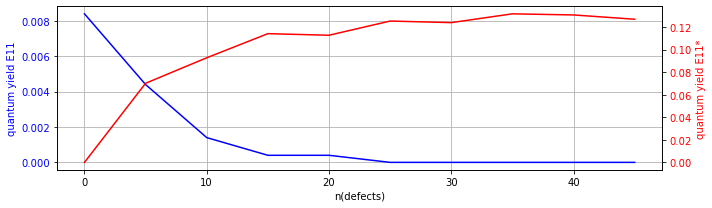

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 3))

color='blue'
ax1.set_xlabel('n(defects)')
ax1.set_ylabel('quantum yield E11', color=color)
ax1.plot(QY[:, 0], QY[:, 2], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(True)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('quantum yield E11*', color=color)
ax2.plot(QY[:, 0], QY[:, 1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()  # otherwise the right y-label is slightly clipped


In [25]:
300/20

15.0

# Effect of tube length

In [37]:
length = np.arange(10, 300, 10)
QY = np.zeros((len(length), 4))
for i, l_nm in enumerate(length):
    QY[i, 0] = l_nm
    QY[i, 1] = round(l_nm/15)
    _, QY[i, 2:] = photons_fate(5000, exciton_walk, {'t_step':1, 'n_defects': int(round(l_nm/15)), 'length': l_nm}) 

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(value='')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(value='')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
filename = 'QY_tube_length'
infile = open(filename,'rb')
QY = pickle.load(infile)
infile.close()

In [58]:
plot = figure(title='Tube length', width=800, height=400)
plot.add_tools(HoverTool())
plot.scatter(QY[:, 0], QY[:, 2], legend='E11* quantum yield', color='red')
plot.scatter(QY[:, 0], QY[:, 3], legend='E11 quantum yield')
show(plot)

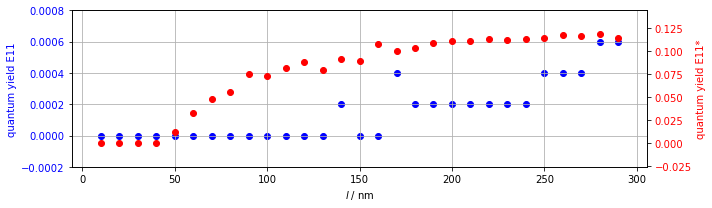

In [57]:
fig, ax1 = plt.subplots(figsize=(10, 3))

color='blue'
ax1.set_xlabel('$l$ / nm')
ax1.set_ylabel('quantum yield E11', color=color)
ax1.scatter(QY[:, 0], QY[:, 3], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.0002, 0.0008)
plt.grid(True)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('quantum yield E11*', color=color)
ax2.scatter(QY[:, 0], QY[:, 2], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()  # otherwise the right y-label is slightly clipped

In [ ]:
length = np.arange(10, 500, 25)
QY = np.zeros((len(length), 4))
for i, l_nm in enumerate(length):
    QY[i, 0] = l_nm
    QY[i, 1] = round(l_nm/15)
    _, QY[i, 2:] = photons_fate(5000, exciton_walk, {'t_step':1, 'n_defects': int(round(l_nm/15)), 'length': l_nm}) 